In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fftpack import fft, fftshift
import wave
import librosa as li
%matplotlib inline
import python_speech_features as psf
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Audio
from sklearn.preprocessing import MinMaxScaler
import librosa as li
import librosa.display
np.seterr(divide='ignore', invalid='ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Insert the input file:
# Listen to the input file:
import __future__
import thinkdsp
import thinkplot

In [2]:
inputfile = 'G:\ΣΧΟΛΗ p12127\Πτυχιακη\MAPS Dataset\Test Dataset\MAPS_AkPnBcht_1\AkPnBcht\ISOL\CH\MAPS_ISOL_CH0.1_F_AkPnBcht.wav'
# G:\ΣΧΟΛΗ p12127\Πτυχιακη\MAPS Dataset\MAPS_AkPnBcht_1\AkPnBcht\ISOL\CH\MAPS_ISOL_CH0.1_F_AkPnBcht.wav
audio = thinkdsp.read_wave(inputfile)
audio.make_audio()

In [3]:
'''We load the file using librosa. Data is stored, sample rate is sr.
We use pre emphasis on the data.
We specify which kind of window (small/big) we have and then we apply it.
We return the needed information for the rest of the preprocessing procedure.
framesize = nfft_length in this notebook they are the same value and ALWAYS SHOULD be.
'''
def extract(inputfile, small_window_size=True):

    data, sr = li.core.load(inputfile,
                        sr=None, # get the original sample rate.
                        mono=True, # from stereo to mono, so we have 1D data
                        offset=0.0, # starting point in seconds.
                        duration=300.0, # in seconds 0.04645 = 2048 frames
                                    # or 8192 samples, 185.8 ms = 4*small window
                        dtype=float # type of data
                        )
    pre_emphasis = 0.95
    data = np.append(data[0], data[1:] - pre_emphasis * data[:-1])
    if small_window_size==True:
        window_size=0.04645
        framesize = int(window_size*sr)
    else:
        window_size=0.04645*4
        framesize = int(window_size*sr-1)
    
    all_frames_length = len(data)
    window_hop_length = 0.01
    #window_size = 0.04645
    overlap = int(sr*window_hop_length)
    number_of_frames = int(all_frames_length/overlap)
    
    return data, sr,  all_frames_length, window_hop_length, window_size, overlap, framesize, number_of_frames

data, sr,  all_frames_length, window_hop_length, window_size, overlap, framesize, number_of_frames = extract(inputfile, small_window_size=True)
# window_size can get 2 possible values, according to the paper we follow.
# small_window = 0.04645, big_window = 0.04645 * 4
print("Frame Size = ", framesize)
print("Overlap = ", overlap)
print("Total frames = ", number_of_frames)
print("Sample Rate = ",sr)

'We load the file using librosa. Data is stored, sample rate is sr.\nWe use pre emphasis on the data.\nWe specify which kind of window (small/big) we have and then we apply it.\nWe return the needed information for the rest of the preprocessing procedure.\nframesize = nfft_length in this notebook they are the same value and ALWAYS SHOULD be.\n'

Frame Size =  2048
Overlap =  441
Total frames =  2185
Sample Rate =  44100


In [4]:
'''We get the number of frames that the wave file has.
We use mod to get the remainder that divides with 0 remainder from 50. 
50 is the FPS we need for each batch, so we need to just zero pad this far.
We return the frames which contain the values of the frames, and the
total_frames which is equal to the number of frames, after the zero pad is done.
Frames are in time domain, NOT in frequency domain.
'''
def zero_pad(framesize, overlap, number_of_frames, data):
    divider, remainder = np.divmod(number_of_frames , 50)
    total_frames = number_of_frames + 50 - remainder +1 # +1 because we later get the 1st order diff. therefore we need +1 frames.
    frames = np.ndarray((total_frames, framesize))
    
    for k in range(total_frames):
        for i in range(framesize):
            if((k*overlap+i)<int(len(data))):
                frames[k][i] = data[k*overlap+i]
            else:
                frames[k][i]=0
    
    return frames, total_frames

frames, total_frames = zero_pad(framesize, overlap, number_of_frames, data)

def frames_shape(inputfile, small_window_size=True):
    data, sr,  all_frames_length, window_hop_length, window_size, overlap, framesize, number_of_frames = extract(inputfile=inputfile, small_window_size=small_window_size)
    frames, total_frames = zero_pad(framesize,overlap, number_of_frames, data)
    return (frames.shape[0]-1)

'We get the number of frames that the wave file has.\nWe use mod to get the remainder that divides with 0 remainder from 50. \n50 is the FPS we need for each batch, so we need to just zero pad this far.\nWe return the frames which contain the values of the frames, and the\ntotal_frames which is equal to the number of frames, after the zero pad is done.\nFrames are in time domain, NOT in frequency domain.\n'

In [5]:
'''This is the vocabulary of our labels. They are the notes in hertz, both in real hz and in normalized form. We also
extract the Nyquist Frequency.
'''
def vocabulary(sr):
    nyqf = sr/2
    hz_notes = np.zeros(90)
    hz_notes[-1] = nyqf
    for i in range(88):
        hz_notes[i+1] = (2**((i-48)/12) * 440)
    # Convert hz_notes to scale[0,1] where 1 = Nyq Freq = sample_rate / 2. 
    # normf = normalized frequencies [0,1]/
    normf = np.zeros(90)
    normf[0] = 0 # first value must be 0.
    normf[-1] = 1 # last value must be 1 = nyq freq.
    for i in range(len(hz_notes)):
        normf[i] = hz_notes[i] / nyqf
    return nyqf, hz_notes, normf
    
nyqf, hz_notes, normf = vocabulary(sr)

'This is the vocabulary of our labels. They are the notes in hertz, both in real hz and in normalized form. We also\nextract the Nyquist Frequency.\n'

In [6]:
'''We first apply the hamming window on each frame.
We then apply the FFT which transforms the data into the frequency domain, from the time domain.
We then get the absolute values of the FFT, saving space and computation time.
We return the absolute values.'''
def transform(frames, framesize, total_frames):
    ham = signal.hamming(framesize)
    # Caution! Only run it once! Else it applys the window again on the windowed
    fft_data = np.ndarray((total_frames, framesize))
    abs_fft_data = np.ndarray((total_frames, framesize))

    for i in range(0, total_frames):
        frames[i] *= ham
        fft_data[i] = np.fft.fft(frames[i])
        abs_fft_data[i] = abs(fft_data[i])**2/(max(abs(fft_data[i])))
    return abs_fft_data

abs_fft_data = transform(frames, framesize, total_frames)
'''Future delete this. Not needed. Watch spectro.'''

'We first apply the hamming window on each frame.\nWe then apply the FFT which transforms the data into the frequency domain, from the time domain.\nWe then get the absolute values of the FFT, saving space and computation time.\nWe return the absolute values.'

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


'Future delete this. Not needed. Watch spectro.'

In [7]:
'''We use all the above information we extracted and we get the magnitude frames.
First apply Hamming window to time-domain frames. Then FFT them, keep only the real part.
Then the power frames that are the energies of the FFT.
Then we create the bins we need to store the 88 possible notes. '''
def spectro(frames, nfft_length, hz_notes, sr):
    
    # Hamming window applied before FFT.
    ham = signal.hamming(nfft_length)
    for i in range(0, frames.shape[0]):
        frames[i] *= ham
        
    # Magnitude of frames (simple fft appliance)
    '''To apply logarithmic characteristics of sound intensity,
    a log-like compression with a multiplication factor 1000 is
    applied on the magnitude of spectrograms
    ''' 
    mag_frames = 10e3*np.abs(np.fft.rfft(frames, nfft_length))
    # Power Spectrum of frames.
    pow_frames = ((1.0 / nfft_length) * ((mag_frames) ** 2))  # Power Spectrum
    
    nfilt = 88 # number of filters we need to have the 88 notes of the midipiano
    high_freq_mel = (2595 * np.log10(1 + (sr / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(0, high_freq_mel, 88 + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    binz = np.floor((nfft_length+1) * hz_points / sr)

    # fb stands for filterbank:
    fb = np.zeros((nfilt, int(np.floor(nfft_length/2 +1))))

    for i in range(1, nfilt + 1):
        filter_left = int(binz[i-1])
        filter_center = int(binz[i])
        filter_right = int(binz[i+1])
        
        for k in range(filter_left, filter_center):
            fb[i-1, k] = (k -binz[i-1]) / (binz[i] - binz[i-1])
        for k in range(filter_center, filter_right):
            fb[i-1, k] = (binz[i+1]- k) / (binz[i+1] - binz[i])
        
    filterbanks = np.dot(pow_frames, fb.T)    
    
    # for better performance:
    
    filterbanks -= (np.mean(filterbanks, axis=0) + 1e-8)
    #filterbanks = np.where(filterbanks==0, np.finfo(float).eps, filterbanks)
    filterbanks = filterbanks**2
    filterbanks = 10*np.log10(filterbanks)
    
    # Get the negative values of filterbanks to equal 0.
    for i in range(filterbanks.shape[0]):
        for j in range(filterbanks.shape[1]):
            if filterbanks[i,j] < 0:
                filterbanks[i,j] = 0
                
    return(filterbanks)


filterbanks = spectro(frames,framesize, hz_notes, sr)
filterbanks

'We use all the above information we extracted and we get the magnitude frames.\nFirst apply Hamming window to time-domain frames. Then FFT them, keep only the real part.\nThen the power frames that are the energies of the FFT.\nThen we create the bins we need to store the 88 possible notes. '

array([[ 0.69225483, 44.58937815, 59.06888961, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.69225483, 44.58937815, 59.06888961, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.69225483, 44.58937815, 59.06888961, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.69225483, 44.58937815, 59.06888961, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.69225483, 44.58937815, 59.06888961, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.69225483, 44.58937815, 59.06888961, ...,  0.        ,
         0.        ,  0.        ]])

'Must get the 1st order difference between the frames, not the banks.\nWe compute the 1st order difference to get another spectrogram.\nIn the paper, it suggests it works better than the pure energies in the filterbanks.\nThe 1st order diff : Get the difference, and then normalise (-1,1)\n'

Text(0.5,1,'Filterbanks Spectrogram')

<Figure size 432x288 with 0 Axes>

(2200, 88)

Text(0.5,1,'firdif')

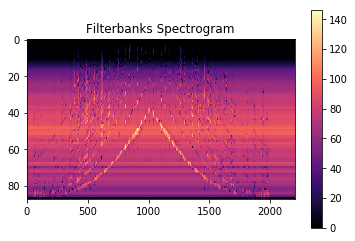

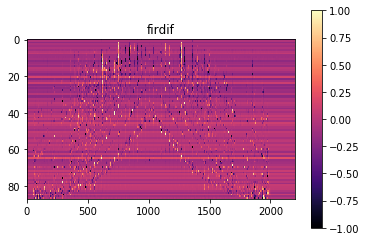

In [8]:
'''Must get the 1st order difference between the frames, not the banks.
We compute the 1st order difference to get another spectrogram.
In the paper, it suggests it works better than the pure energies in the filterbanks.
The 1st order diff : Get the difference, and then normalise (-1,1)
'''
def firdif(fb):
    banks = np.diff(fb, axis=0)
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler = scaler.fit(banks)
    banks = scaler.transform(banks)
    return banks

plt.imshow(np.flipud(filterbanks.T),cmap="magma",  aspect=15) #magma
plt.title("Filterbanks Spectrogram")
plt.colorbar()

plt.figure()
bankz = firdif(filterbanks)
bankz.shape
plt.imshow(np.flipud(bankz.T),cmap="magma", aspect=15)
plt.title('firdif')
plt.colorbar()

## Final output for preprocessing!
window_size can have another value

In [9]:
'''Finally, we gather all the functions we created above, uniting them in one, so it is easy to call it
    on another file. We just need the path and which of the 2 windows we would like to compute, and returns
    the first order difference of the filterbanks.'''
def process(inputfile, small_window_size):
    data, sr,  all_frames_length, window_hop_length, window_size, overlap, framesize, number_of_frames = extract(inputfile=inputfile, small_window_size=small_window_size)
    nyqf, hz_notes, normf = vocabulary(sr)
    frames, total_frames = zero_pad(framesize,overlap, number_of_frames, data)
    filterbanks = spectro(frames, framesize , hz_notes, sr)
    fbanks = firdif(filterbanks)
    return fbanks

'Finally, we gather all the functions we created above, uniting them in one, so it is easy to call it\n    on another file. We just need the path and which of the 2 windows we would like to compute, and returns\n    the first order difference of the filterbanks.'

In [10]:
feats = process(inputfile='G:\\ΣΧΟΛΗ p12127\\Πτυχιακη\\MAPS Dataset\\Music Dataset\\Train Dataset\\MAPS_AkPnBcht_2\\AkPnBcht\\MUS\\MAPS_MUS-gra_esp_4_AkPnBcht.wav',small_window_size=True)

In [11]:
feats.shape

(28500, 88)